In [2]:
%load_ext autoreload
%autoreload 2

In [186]:
# import
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Introduction
In this blog post, I will train a random forest model to predict employment status based on demographic characteristics excluding race. Then, to see whether my algorithm displays bias with respect to race, I will perform a fairness audit and discuss its results.

## Data Preparation

The data I used is the PUMS data for Massachusetts in 2018. I firstly examined the data, and then selected possible features for training, excluding race for later bias audit and employment status which is the predicting target. After splitting the training and testing datasets, I turned the training data back to data frame to facilitate further manipulation.

In [120]:
# download the PUMS data for the state of MA
STATE = "MA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000024,1,1,3301,1,25,1013097,47,77,...,47,46,4,92,46,50,49,4,89,4
1,P,2018GQ0000063,1,1,1600,1,25,1013097,16,18,...,33,30,16,16,18,2,18,31,16,15
2,P,2018GQ0000075,1,1,703,1,25,1013097,60,28,...,110,116,57,8,60,107,60,62,109,110
3,P,2018GQ0000088,1,1,3301,1,25,1013097,72,22,...,71,74,10,10,129,128,10,73,128,70
4,P,2018GQ0000098,1,1,701,1,25,1013097,21,50,...,37,18,24,0,39,19,20,39,19,36


In [121]:
# focus on possible features and examine them
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,77,19.0,3,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,2,1,6.0
1,18,18.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,9,1.0
2,28,21.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,1.0
3,22,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
4,50,1.0,5,17,1,NaN,1,1.0,4.0,1,1,2,1,1.0,2,1,6.0


In [122]:
# exclude ESR (employment status) and RAC1P (race)
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [123]:
# construct a BasicProblem that expresses our wish to use these features to predict employment status ESR
# using the race RAC1P as the group label
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

In [124]:
# train-test split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [129]:
# turn training data back to data frame
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

## Basic Descriptives
Before conducting any training, I first explored the basic descriptives of the training dataset, a summary of which is at the end of this section. The race in this dataset is categroized into 9 groups; while the rest of the code and explanation will mainly refer to each group by number, here is whay they represent:

    Group 1: White alone
    Group 2: Black or African American alone
    Group 3: American Indian alone
    Group 4: Alaska Native alone
    Group 5: American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races
    Group 6: Asian alone
    Group 7: Native Hawaiian and Other Pacific Islander alone
    Group 8:  Some Other Race alone
    Group 9: Two or More Races

While I conducted analysis for all of these groups, I will focus on the results of group 1, 2, and 6, which are white, black, and asian alone respectively.<br>

We firstly examined the number of total individuals in the dataset and the overall employment status count.

In [132]:
# how many individuals
len(df)

56104

In [133]:
# how many are employed (label = 1)
df.groupby("label").size()

label
False    27733
True     28371
dtype: int64

In [249]:
proportion_employed = 28371/56104
print(f"{proportion_employed = }")

proportion_employed = 0.5056858691002424


Then, we examined the count and percentage for each group .

In [211]:
# how many are in each racial group
df.groupby("group").size()

group
1    45515
2     3405
3       66
4        1
5       24
6     3778
7       24
8     1698
9     1593
dtype: int64

In [144]:
# in each group, what proportion of individuals are employed
df.groupby("group")["label"].mean().reset_index()

,group,label
0,1,0.514556
1,2,0.456681
2,3,0.500000
3,4,1.000000
4,5,0.500000
5,6,0.510058
6,7,0.625000
7,8,0.469376
8,9,0.383553


Next, we examined the sex proportion in each group and visualized it.

In [169]:
# in each group, how many individuals are in each sex
df.groupby(["group","SEX"]).size()

group  SEX
1      1.0    21910
       2.0    23605
2      1.0     1701
       2.0     1704
3      1.0       31
       2.0       35
4      1.0        1
5      1.0       12
       2.0       12
6      1.0     1742
       2.0     2036
7      1.0       10
       2.0       14
8      1.0      845
       2.0      853
9      1.0      766
       2.0      827
dtype: int64

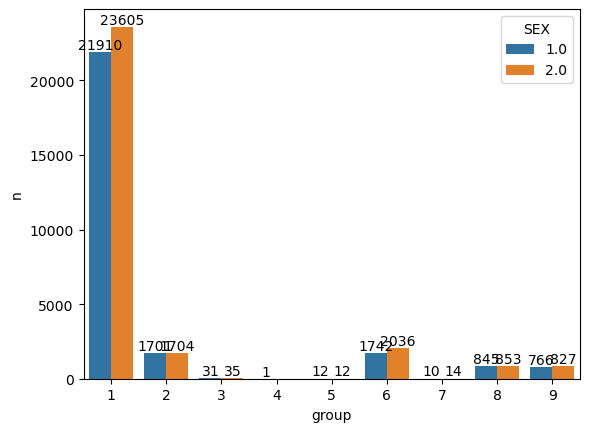

In [250]:
# visualize sex proportion in each group
sex_count = df.groupby(["group","SEX"]).size().reset_index(name = "n")

# plot
ax = sns.barplot(x="group", y="n", hue="SEX", data=sex_count)
for i in ax.containers:
    ax.bar_label(i,)

As shown in the above figure, the number of males and females in each group is relatively balanced. <br> Next, we explore the employment status for each sex in individual groups.

In [ ]:
# in each group, what is the proportion of employed individuals in each sex
df.groupby(["group", "SEX"])["label"].mean()

group  SEX
1      1.0    0.538430
       2.0    0.492396
2      1.0    0.432099
       2.0    0.481221
3      1.0    0.354839
       2.0    0.628571
4      1.0    1.000000
5      1.0    0.583333
       2.0    0.416667
6      1.0    0.552239
       2.0    0.473969
7      1.0    0.600000
       2.0    0.642857
8      1.0    0.484024
       2.0    0.454865
9      1.0    0.356397
       2.0    0.408706
Name: label, dtype: float64

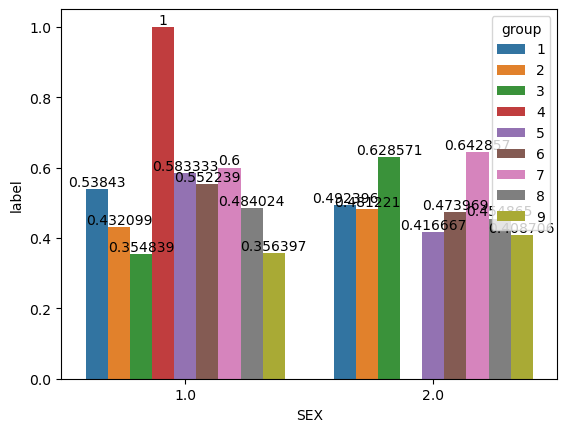

In [174]:
# plot sex and label in each group
proportion = df.groupby(["group", "SEX"])["label"].mean().reset_index()
ax = sns.barplot(x="SEX", y="label", hue="group", data=proportion)
for i in ax.containers:
    ax.bar_label(i,)

Here is a summary of the binary sex proportion in employed individuals for each racial group (see above table for specific percentages):

    group1: the employment rate is higher in males than females
    group2: the employment rate is lower in males than females
    group3: the employment rate is lower in males than females
    group4: the employment rate is higher in males than females 
    group5: the employment rate is higher in males than females
    group6: the employment rate is higher in males than females
    group7: the employment rate is lower in males than females
    group8: the employment rate is higher in males than females
    group9: the employment rate is lower in males than females 

As mentioned previously, we will focus on group 1, 2, and 6. 
In the White alone group, although the employment rate is higher in males than females, the difference is not big (about 5%). In the Black and African American alone group, the employment rate is lower in males than females, but the difference is not that big too (about 5%). In the Asian alone group, the employment rate is higher in males than females, and the percentage differences is slightly larger than the aforementioned two groups, which is about 8%.

### Summary of Basic Descriptives
1. How many individuals are in the data?

    56104 of these individuals are in the data.

2. Of these individuals, what proportion have target label equal to 1? In employment prediction, these would correspond to employed individuals.

    51% (28371 individuals) of these individuals are employed

3. Of these individuals, how many are in each of the groups? 

    Of these individuals, 
    45515 are in group 1 (White alone), 
    3405 in group 2 (Black or African American alone), 
    66 in group 3 (American Indian alone), 
    1 in group 4 (Alaska Native alone), 
    24 in group 5 (American Indian and Alaska Native tribes specified, or American Indian or Alaska Native, not specified and no other races), 
    3778 in group 6 (Asian alone), 
    24 in group 7 (Native Hawaiian and Other Pacific Islander alone), 
    1698 in group 8 (Some Other Race alone), and 
    1593 in group 9 (Two or More Races).

4. In each group, what proportion of individuals have target label equal to 1?

    In group 1, 51.5% of individuals are employed.
    In group 2, 45.7% of individuals are employed.
    In group 3, 50.% of individuals are employed.
    In group 4, 100.0% of individuals are employed.
    In group 5, 50.0% of individuals are employed.
    In group 6, 51.0% of individuals are employed.
    In group 7, 62.5% of individuals are employed.
    In group 8, 46.9% of individuals are employed.
    In group 9, 38.4% of individuals are employed.

5. Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group label. For example, if you chose race (RAC1P) as your group, then you could also choose sex (SEX) and compute the proportion of positive labels by both race and sex. This might be a good opportunity to use a visualization such as a bar chart, e.g. via the seaborn package.

    Except in group 2, 3, 7, and 9, the employement rate is higher in males than in females.

## Model Training
After getting a sense on the basic descriptives of the dataset, I conducted model traning using the random forest classifier. I used cross-validation to find out the best max depth for the model and plotted the changes of cross-validation score (cvs) with the max depth. The results is shown below.

In [185]:
# initialize variables
best_depth = 0
max_score = 0
history = []

# find the best depth
for d in range(1,30):
    # fit the model
    rf = RandomForestClassifier(max_depth = d)
    rf.fit(X_train, y_train)
    
    # cross-validation
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
    mean_score = cv_scores.mean()
    # print(f"Depth = {d}, score = {mean_score.round(3)}")
    history.append(mean_score)
    
    # update the max score and the best depth
    if mean_score > max_score:
        best_depth = d
        max_score = mean_score

print("Best depth = ", best_depth)
print("Max cvs = ", max_score)

Best depth =  14
Max cvs =  0.8343968202604584


Text(0, 0.5, 'CVS')

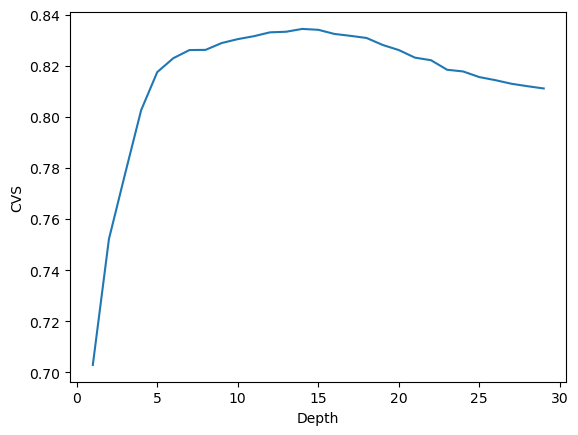

In [187]:
# plot the history of cvs
plt.plot(range(1, 30), history)
plt.xlabel("Depth")
plt.ylabel("CVS")

## Model Auditing
In this section, I firstly trained the model using the parameters I found out in the last section. Then, I applied the model on the test dataset and performed an audit for racial biases.

In [189]:
# train the model and get the predictions
rf = RandomForestClassifier(max_depth = best_depth)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

### Overall Measures
First, I took a look at the measures of the entire test dataset, specifically, the positive predictive value (PPV), false negative rate (FNR), and false positive rate (FPR).

In [191]:
cm = confusion_matrix(y_test, y_hat)
TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

test_score = rf.score(X_test, y_test)
PPV = TP / (TP + FP)
FNR = FN / (TP + FN)
FPR = FP / (TN + FP)

print(f"overall accuracy = {test_score}")
print(f"{PPV = }")
print(f"{FNR = }")
print(f"{FPR = }")

overall accuracy = 0.8290439865972766
PPV = 0.7805332568807339
FNR = 0.1373574144486692
FPR = 0.1984445884640311


An overall accuracy of about 83% showed that the model was quite accurate. The FPR is 7% higher than the FNR, indicating that the model is more likely to wrongly predict that someone is employed while this person actually is not, compared to wrongly predicting that someone is not employed while the person actually is.

### By-group Measures
Then, we calculated the same measures as above for individual groups.

In [252]:
unique_groups = set(group_test)
for group in unique_groups:
    # Select the data points belonging to the current group
    group_mask_test = (group_test == group)
    X_group_test, y_group_test = X_test[group_mask_test], y_test[group_mask_test]

    # Make predictions on the current group
    y_hat = model.predict(X_group_test)

    # Calculate and print the accuracy for the current group
    test_score = rf.score(X_group_test, y_group_test)
    
    # calculate PPV, FNR, FPR
    cm = confusion_matrix(y_group_test, y_hat)
    TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

    PPV = TP / (TP + FP)
    FNR = FN / (TP + FN)
    FPR = FP / (TN + FP)
    
    # calibration
    y_group_test[y_hat == 1].mean()
    y_group_test[y_hat == 0].mean()
    
    print(f"For group {group}:")    
    print(f"    accuracy = {test_score}")
    print(f"    {PPV = }")
    print(f"    {FNR = }")
    print(f"    {FPR = }\n")

For group 1:
    accuracy = 0.8297072957623416
    PPV = 0.6929667975722956
    FNR = 0.16372253339077983
    FPR = 0.25282963398500663

For group 2:
    accuracy = 0.8252551020408163
    PPV = 0.745
    FNR = 0.19021739130434784
    FPR = 0.24519230769230768

For group 3:
    accuracy = 0.8823529411764706
    PPV = 0.9090909090909091
    FNR = 0.0
    FPR = 0.14285714285714285

For group 5:
    accuracy = 0.6
    PPV = 0.5
    FNR = 0.5
    FPR = 0.5714285714285714

For group 6:
    accuracy = 0.8182807399347116
    PPV = 0.5765199161425576
    FNR = 0.13522012578616352
    FPR = 0.33610648918469216

For group 7:
    accuracy = 1.0
    PPV = 1.0
    FNR = 0.0
    FPR = 0.0

For group 8:
    accuracy = 0.8191721132897604
    PPV = 0.7322175732217573
    FNR = 0.18604651162790697
    FPR = 0.26229508196721313

For group 9:
    accuracy = 0.8597402597402597
    PPV = 0.8109243697478992
    FNR = 0.1187214611872146
    FPR = 0.2710843373493976



Again, we will choose to focus on group 1, 2, and 6. The overall accuracy for these groups are relatively similar. Groups 1 and 2 have similar FNR and FPR too. Group 6 has a lower FNR and a higher FPR compared to the previous two groups. This means that the model is more likely to wrongly predict that an Asian is employed when he/she actually is not, compared to the same situations for white and black people. Meanwhile, the model is less likely to wrongly predict that an Asian is not employed while he/she actually is.

### Bias Measures
Lastly, we calculated three different kinds of bias measures based on the paper of Chouldechove (2017).

#### Calibration
The first measure is calibration. Based on Chouldechove's research, good calibration for this binary employment classification means that the fraction of predicted employed individuals who actually get employed is the same across groups (2017).

In [247]:
# get the unique groups
unique_groups = set(group_test)

# initialize arrays for later printing
pred_pos_actu_pos_arr = []
pred_neg_actu_pos_arr = []

for group in unique_groups:
    # select the data points belonging to the current group
    group_mask_test = (group_test == group)
    X_group_test, y_group_test = X_test[group_mask_test], y_test[group_mask_test]

    # make predictions on the current group
    y_hat = model.predict(X_group_test)
    
    # calibration
    pred_pos_actu_pos = y_group_test[y_hat == 1].mean()
    pred_neg_actu_pos = y_group_test[y_hat == 0].mean()
    
    pred_pos_actu_pos_arr.append(pred_pos_actu_pos.round(3))
    pred_neg_actu_pos_arr.append(pred_neg_actu_pos.round(3))
    
#     print(f"For group {group}:")    
#     print(f"    percentage of actually employed individuals in positively predicted individuals = {pred_pos_actu_pos.round(3)}")
#     print(f"    percentage of actually employed individuals in negatively predicted individuals = {pred_neg_actu_pos.round(3)}\n")
    
print("Calibration comparison 1:")

for i in range(len(FNR_arr)):
    print(f"    For group {list(unique_groups)[i]}, percentage of actually employed individuals in positively predicted individuals = {pred_pos_actu_pos_arr[i]}")    

print("Calibration comparison 2:")
for i in range(len(FNR_arr)):
    print(f"    For group {list(unique_groups)[i]}, percentage of actually employed individuals in negatively predicted individuals = {pred_neg_actu_pos_arr[i]}")    

Calibration comparison 1:
    For group 1, percentage of actually employed individuals in positively predicted individuals = 0.747
    For group 2, percentage of actually employed individuals in positively predicted individuals = 0.755
    For group 3, percentage of actually employed individuals in positively predicted individuals = 0.857
    For group 5, percentage of actually employed individuals in positively predicted individuals = 0.429
    For group 6, percentage of actually employed individuals in positively predicted individuals = 0.664
    For group 7, percentage of actually employed individuals in positively predicted individuals = 1.0
    For group 8, percentage of actually employed individuals in positively predicted individuals = 0.738
    For group 9, percentage of actually employed individuals in positively predicted individuals = 0.729
Calibration comparison 2:
    For group 1, percentage of actually employed individuals in negatively predicted individuals = 0.164
    F

The percentage of actually employed individuals in positively predicted individuals was similar between the groups of blacks and whites but was higher than the Asian group by almost 10%. The percentage of actually employed individuals in negatively predicted individuals was also similar between the groups of whites and blacks (the white group has a slightly lower percentage), and that of the Asian group was lower than both of the previous groups. The results indicated that the model was to certain extent calibrated but also possess biases.

#### Error Rate Balance
The second bias measure is the error rate balance. According to Chouldechova's definition, error rate balance is achieved when the false positive and false negative error rates are equal across groups (2017).

In [243]:
unique_groups = set(group_test)
FNR_arr = []
FPR_arr = []

for group in unique_groups:
    # select the data points belonging to the current group
    group_mask_test = (group_test == group)
    X_group_test, y_group_test = X_test[group_mask_test], y_test[group_mask_test]

    # make predictions on the current group
    y_hat = model.predict(X_group_test)
    
    # calculate PPV, FNR, FPR
    cm = confusion_matrix(y_group_test, y_hat)
    TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

    FNR = FN / (TP + FN)
    FPR = FP / (TN + FP)
    FNR_arr.append(FNR)
    FPR_arr.append(FPR)

print("FNR comparison:")
for i in range(len(FNR_arr)):
    print(f"    For group {list(unique_groups)[i]}, FNR = {FNR_arr[i]}")    

print("FPR comparison:")
for i in range(len(FNR_arr)):
    print(f"    For group {list(unique_groups)[i]}, FPR = {FPR_arr[i]}")    

FNR comparison:
    For group 1, FNR = 0.16372253339077983
    For group 2, FNR = 0.19021739130434784
    For group 3, FNR = 0.0
    For group 5, FNR = 0.5
    For group 6, FNR = 0.13522012578616352
    For group 7, FNR = 0.0
    For group 8, FNR = 0.18604651162790697
    For group 9, FNR = 0.1187214611872146
FPR comparison:
    For group 1, FPR = 0.25282963398500663
    For group 2, FPR = 0.24519230769230768
    For group 3, FPR = 0.14285714285714285
    For group 5, FPR = 0.5714285714285714
    For group 6, FPR = 0.33610648918469216
    For group 7, FPR = 0.0
    For group 8, FPR = 0.26229508196721313
    For group 9, FPR = 0.2710843373493976


Like previously discussed in the by-group measures, groups 1 and 2 have similar FNR and FPR. Group 6 has a lower FNR and a higher FPR, meaning that the model is more likely to wrongly predict that an Asian is employed when he/she actually is not, compared to the same situations for white and black people. Meanwhile, the model is less likely to wrongly predict that an Asian is not employed while he/she actually is.

#### Statistical Parity
The last measure is statistical parity. According to Chouldechova, if the proportion of individuals classified as positive (employed) is the same for each group, then statistical parity is achieved (2017). This is represented by the overall positive rate (PR).

In [234]:
unique_groups = set(group_test)
for group in unique_groups:
    # select the data points belonging to the current group
    group_mask_test = (group_test == group)
    X_group_test, y_group_test = X_test[group_mask_test], y_test[group_mask_test]

    # make predictions on the current group
    y_hat = model.predict(X_group_test)

    # calculate and print the accuracy for the current group
    test_score = rf.score(X_group_test, y_group_test)
    
    # calculate PPV, FNR, FPR
    cm = confusion_matrix(y_group_test, y_hat)
    TP, FP, FN, TN = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # statistical parity
    PR = (TP + FP) / (TP+FP+TN+FN)

    print(f"For group {group}, PR = {PR.round(3)}")    

For group 1, PR = 0.489
For group 2, PR = 0.51
For group 3, PR = 0.647
For group 5, PR = 0.533
For group 6, PR = 0.519
For group 7, PR = 0.333
For group 8, PR = 0.521
For group 9, PR = 0.618


There is barely difference in PR across groups 1, 2, and 6, indicating that the model exhibits statistical parity in terms of these three groups.

## Concluding Discussion
The prediction model for employment status could be used for companies to identify potential candidates for job positions. It could also be used by the government agencies involved in the labor market and policy-making to understand employment trends and design targeted interventions. Non-profit organizations that focus on helping unemployed individuals could also leverage the model to find individuals to help and match them with proper opportunities. Companies could also use this model to predict income levels and design algorithms to give targeted advertisements during internet browsing.

Deploying the model without properly adjusting for the biases could result in perpetuating existing stereotypes and disparities in employment outcomes. It could also lead to unequal opportunities and discriminatory decision-making against certain racial groups.

Although I displayed results for all the racial groups, I only focused on the white alone, black alone, and Asian alone groups for my bias analysis. My model exhibits moderate calibration biases and error rate imbalance, reinforcing the hard-working Asian stereotype and the opposite stereotype for whites and blacks. For the calibration, it is more likely to predict that a person is employed when he/she actually is in the Asian group compared to the other two groups. It is also less likely to predict that a person is not employed when he/she actually is in the Asian group. For the error rate, the Asian group has a lower FNR and a higher FPR compared to the other two groups, meaning that the model is more likely to wrongly predict that an Asian is employed when he/she actually is not, compared to the same situations for white and black people. Meanwhile, the model is less likely to wrongly predict that an Asian is not employed while he/she actually is.

In terms of the three groups I chose to focus on, the model has statistical parity, since the proportion of individuals classified as employed is about the same across these groups.

Beyond bias, another concern of deploying my model is private information disclosure. Companies could scrape individuals' demographic information online without their consent, and then use this information to feed the model and make predictions. Regardless of the fact the results do good or harm to these individuals, they did not have any choice in this whole process and would be victims of privacy disclosure. Furthermore, deploying this kind of model without transparency in the algorithms may lead to automated decision-making that gives people a false sense of authority, potentially harming already marginalized groups.

To address these problems, the way that the algorithm works should be transparent to the public, allowing an open eye to examine the potential biases the model may cause. In addition, more comprehensive ethical guidelines and regulations for using this kind of system should be further developed, which may include measures such as proving that this algorithm has sufficient emphasis on and corresponding adjustment for its biases. 